In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import kneighbors_graph
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load datasets

In [3]:
file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/original_cleaned_dataset.csv"
df_original = pd.read_csv(file_path)
display(df_original)


file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/smote_dataset.csv"
df_smote = pd.read_csv(file_path)
display(df_smote)


file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/oversampled_dataset.csv"
df_oversampled = pd.read_csv(file_path)
display(df_oversampled)


file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/adasyn_dataset.csv"
df_adasyn = pd.read_csv(file_path)
display(df_adasyn)


file_path = "https://raw.githubusercontent.com/dths8/DSA4263_Vehicle-Insurance-Fraud-Detection/refs/heads/main/data/test_dataset.csv"
df_test = pd.read_csv(file_path)
display(df_test)




,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,capital-gains,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,-1.216403,-1.198374,2,-0.222383,0.870387,-0.479476,-0.369542,1,3,1.136967,...,False,False,False,False,False,False,False,False,False,0
1,0.487121,0.443534,0,-1.039966,-1.123505,-0.479476,1.438128,0,3,1.054406,...,False,False,False,False,False,False,False,False,False,0
2,-0.442864,-0.541611,1,-1.039966,-1.085930,-0.479476,-0.724956,1,2,0.734931,...,False,False,False,False,False,False,False,False,False,0
3,2.112422,2.413823,0,1.412784,-0.488623,-0.479476,1.595553,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,0
4,-0.729682,-1.198374,1,-0.222383,0.101882,-0.479476,-0.750323,0,6,1.571308,...,False,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.495812,0.334073,1,-1.039966,0.332536,-0.479476,1.450156,0,1,-0.901927,...,True,False,False,False,False,False,False,False,False,0
796,-0.208195,-0.103769,1,1.412784,0.183260,-0.479476,-0.342276,0,1,0.580579,...,False,False,False,False,False,False,False,False,False,1
797,-0.955660,-0.979453,1,1.412784,-0.945997,-0.479476,-0.817441,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,0
798,-1.199020,-0.979453,2,-1.039966,-3.162266,-0.479476,1.494361,0,1,-0.144521,...,False,False,False,False,False,False,False,False,False,1


,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,capital-gains,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,-1.216403,-1.198374,2,-0.222383,0.870387,-0.479476,-0.369542,1,3,1.136967,...,False,False,False,False,False,False,False,False,False,0
1,0.487121,0.443534,0,-1.039966,-1.123505,-0.479476,1.438128,0,3,1.054406,...,False,False,False,False,False,False,False,False,False,0
2,-0.442864,-0.541611,1,-1.039966,-1.085930,-0.479476,-0.724956,1,2,0.734931,...,False,False,False,False,False,False,False,False,False,0
3,2.112422,2.413823,0,1.412784,-0.488623,-0.479476,1.595553,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,0
4,-0.729682,-1.198374,1,-0.222383,0.101882,-0.479476,-0.750323,0,6,1.571308,...,False,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0.008352,-0.158965,0,0.182930,0.662935,2.572669,1.647064,1,3,-0.901927,...,False,False,False,False,True,False,True,False,False,1
1202,-0.853249,-0.914614,0,-1.039966,-0.649257,-0.479476,1.597628,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,1
1203,1.347811,1.320072,0,-0.302227,0.590675,-0.479476,-0.442188,0,3,-0.024453,...,False,False,False,False,False,False,False,False,False,1
1204,-0.484868,-0.649545,1,-0.222383,-0.203316,-0.479476,-0.330141,0,4,0.843972,...,False,False,False,False,False,False,False,False,False,1


,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,capital-gains,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,-1.216403,-1.198374,2,-0.222383,0.870387,-0.479476,-0.369542,1,3,1.136967,...,False,False,False,False,False,False,False,False,False,0
1,0.487121,0.443534,0,-1.039966,-1.123505,-0.479476,1.438128,0,3,1.054406,...,False,False,False,False,False,False,False,False,False,0
2,-0.442864,-0.541611,1,-1.039966,-1.085930,-0.479476,-0.724956,1,2,0.734931,...,False,False,False,False,False,False,False,False,False,0
3,2.112422,2.413823,0,1.412784,-0.488623,-0.479476,1.595553,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,0
4,-0.729682,-1.198374,1,-0.222383,0.101882,-0.479476,-0.750323,0,6,1.571308,...,False,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2.060962,2.007444,1,-0.315727,-0.964832,-0.479476,1.401506,0,2,0.742016,...,False,False,False,False,True,False,False,False,False,1
1001,1.576493,1.510497,2,1.206320,-1.524775,-0.479476,-0.343756,1,5,-0.901927,...,True,False,False,False,False,False,False,False,False,1
1002,-0.320146,-0.569929,1,1.328177,0.084869,-0.366810,1.460166,0,1,2.076181,...,False,False,True,False,False,False,False,False,False,1
1003,0.018442,-0.226717,0,-0.222383,0.449529,-0.479476,-0.540978,1,1,1.134458,...,False,False,False,False,False,False,True,False,False,1


,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,capital-gains,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,-1.216403,-1.198374,2,-0.222383,0.870387,-0.479476,-0.369542,1,3,1.136967,...,False,False,False,False,False,False,False,False,False,0
1,0.487121,0.443534,0,-1.039966,-1.123505,-0.479476,1.438128,0,3,1.054406,...,False,False,False,False,False,False,False,False,False,0
2,-0.442864,-0.541611,1,-1.039966,-1.085930,-0.479476,-0.724956,1,2,0.734931,...,False,False,False,False,False,False,False,False,False,0
3,2.112422,2.413823,0,1.412784,-0.488623,-0.479476,1.595553,0,2,-0.901927,...,False,False,False,False,False,False,False,False,False,0
4,-0.729682,-1.198374,1,-0.222383,0.101882,-0.479476,-0.750323,0,6,1.571308,...,False,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,-0.315359,-0.150307,1,0.369962,0.297006,-0.479476,-0.345165,0,0,0.621785,...,False,False,False,False,False,False,False,False,False,1
1199,-0.530821,-0.633746,1,0.884982,-0.082826,-0.479476,-0.358383,0,1,0.102053,...,False,False,False,False,False,False,False,False,False,1
1200,0.058482,-0.005947,0,0.682134,0.053727,-0.479476,-0.344180,0,0,0.788024,...,False,False,False,False,False,False,False,False,False,1
1201,-0.198649,0.019226,2,0.681420,-1.387455,-0.479476,-0.040977,0,1,0.051981,...,False,False,False,False,False,False,False,False,False,1


,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,capital-gains,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported
0,-1.772656,-0.760532,2,-0.222383,0.494309,-0.479476,-0.835148,1,1,1.302088,...,False,False,False,False,False,False,False,False,False,0
1,-1.642284,-0.541611,1,1.412784,1.352224,-0.479476,1.499929,0,2,0.300590,...,False,False,False,False,False,False,False,True,False,1
2,-0.355950,-0.213229,1,-1.039966,-0.317384,2.133471,-0.835050,0,3,-0.901927,...,False,False,False,False,False,False,True,False,False,0
3,0.461047,0.443534,0,-0.222383,-1.153746,-0.479476,-0.449733,0,3,0.968255,...,False,False,False,False,False,False,False,False,False,0
4,0.426281,0.771915,0,-1.039966,0.417111,-0.479476,-0.329006,0,4,0.996972,...,False,False,False,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.216886,-0.760532,2,1.412784,-0.039854,-0.479476,-0.850664,0,6,-0.901927,...,False,False,False,False,False,False,False,False,False,0
196,0.226378,0.334073,0,-0.222383,-0.955954,-0.479476,-0.350021,0,4,-0.901927,...,False,False,False,False,False,False,False,False,False,0
197,-0.434173,-0.322690,1,1.412784,0.233989,2.568963,1.391034,0,5,1.556950,...,False,False,False,False,False,False,False,False,False,0
198,-0.182121,-0.103769,1,-1.039966,1.177133,-0.479476,1.475928,0,5,-0.176827,...,False,False,False,False,False,False,False,False,False,1


# Creating graph (Test)


Using KNN (feature similarity graph) as there are no domain relations.
- Only independent samples; knn gives fixed num of edges per node

Data(x=[200, 126], edge_index=[2, 1000], y=[200], edge_weight=[1000])
Nodes: 200, Edges: 1000


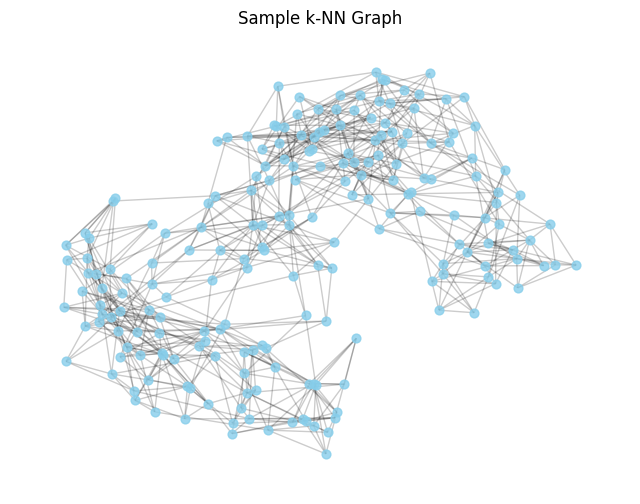

In [9]:
X_test = df_test.drop(columns=['fraud_reported'])
X_test = X_test.select_dtypes(include=['float64', 'int64', 'bool']).astype(float)
y_test = df_test['fraud_reported']

# knn to build graph
k = 5
A_test = kneighbors_graph(X_test, n_neighbors=k, mode='distance', include_self=False)
A_test.data = np.exp(-A_test.data**2 / X_test.shape[1])
A_test = A_test.tocoo()

edge_index_test = torch.from_numpy(np.vstack((A_test.row, A_test.col)).astype(np.int64))
edge_weight_test = torch.tensor(A_test.data, dtype=torch.float)
x_test = torch.tensor(X_test.values, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

graph_data_test = Data(x=x_test, edge_index=edge_index_test, edge_weight=edge_weight_test, y=y_test_torch)

print(graph_data_test)
print(f"Nodes: {graph_data_test.num_nodes}, Edges: {graph_data_test.num_edges}")


#visualise graph
num_sub_nodes = min(200, graph_data_test.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data_test.edge_index[:, :min(graph_data_test.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph")
plt.axis("off")
plt.show()


# Creating graph (Test, Manhattan)

Data(x=[200, 126], edge_index=[2, 1000], y=[200], edge_weight=[1000])
Nodes: 200, Edges: 1000


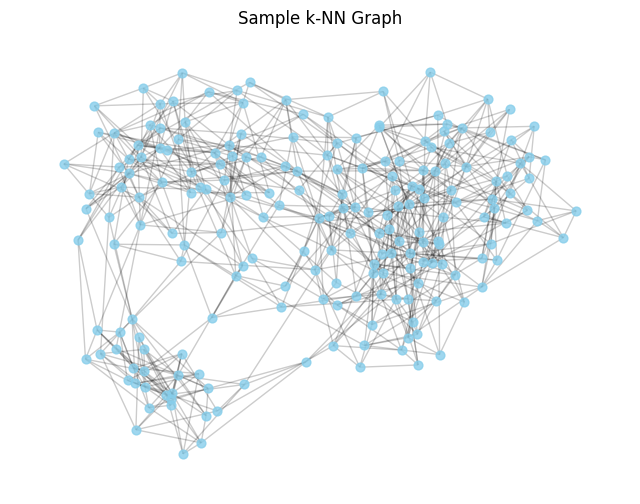

In [7]:
X_test = df_test.drop(columns=['fraud_reported'])
X_test = X_test.select_dtypes(include=['float64', 'int64', 'bool']).astype(float)
y_test = df_test['fraud_reported']

# knn to build graph
k = 5
A_test = kneighbors_graph(X_test, n_neighbors=k, mode='distance', include_self=False, metric='minkowski', p=1)
A_test.data = np.exp(-A_test.data**2 / X_test.shape[1])
A_test = A_test.tocoo()

edge_index_test = torch.from_numpy(np.vstack((A_test.row, A_test.col)).astype(np.int64))
edge_weight_test = torch.tensor(A_test.data, dtype=torch.float)
x_test = torch.tensor(X_test.values, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

graph_data_test_man = Data(x=x_test, edge_index=edge_index_test, edge_weight=edge_weight_test, y=y_test_torch)

print(graph_data_test_man)
print(f"Nodes: {graph_data_test_man.num_nodes}, Edges: {graph_data_test_man.num_edges}")


#visualise graph
num_sub_nodes = min(200, graph_data_test_man.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data_test_man.edge_index[:, :min(graph_data_test_man.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph")
plt.axis("off")
plt.show()


# Creating graph (Original)

Data(x=[800, 126], edge_index=[2, 4000], y=[800], edge_weight=[4000])
Nodes: 800, Edges: 4000


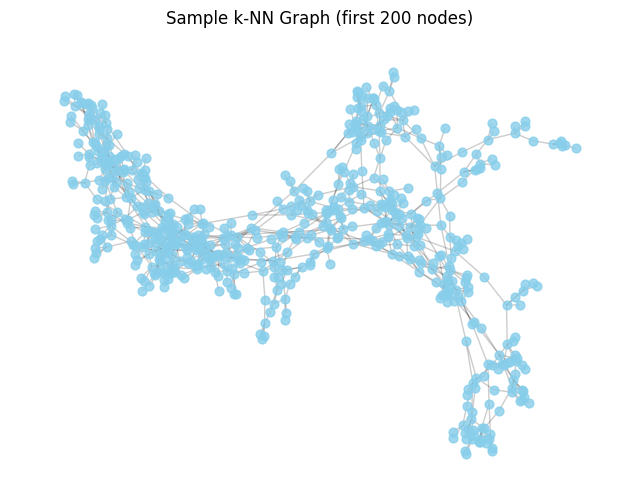

In [10]:

X = df_original.drop(columns=['fraud_reported'])
X = X.select_dtypes(include=['float64', 'int64', 'bool'])
X = X.astype(float) # convert bool to float for PyTorch
y = df_original['fraud_reported'].values


k = 5
A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
A.data = np.exp(-A.data**2 / X.shape[1])
A = A.tocoo()


# convert to pyTorch geometric data for gnn
edge_index = torch.from_numpy(
    np.vstack((A.row, A.col)).astype(np.int64)
)
edge_weight = torch.tensor(A.data, dtype=torch.float)
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

print(graph_data)
print(f"Nodes: {graph_data.num_nodes}, Edges: {graph_data.num_edges}")




num_sub_nodes = min(200, graph_data.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data.edge_index[:, :min(graph_data.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph (first 200 nodes)")
plt.axis("off")
plt.show()


# GCN (Original)

In [11]:
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=graph_data.y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

# define model
class FraudGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



#training and eval
def train_and_evaluate(graph_data, hidden_channels, lr, dropout, epochs=100):
    model = FraudGCN(
        in_channels=graph_data.num_features,
        hidden_channels=hidden_channels,
        out_channels=2,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    out = model(graph_data)
    preds = out[graph_data.test_mask].argmax(dim=1).detach()
    y_true = graph_data.y[graph_data.test_mask].detach()

    recall = recall_score(y_true, preds, zero_division=0)
    precision = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    accuracy = accuracy_score(y_true, preds)

    # get pred distribution
    unique, counts = torch.unique(preds, return_counts=True)
    dist_dict = {int(u): int(c) for u, c in zip(unique, counts)}
    print(f"Prediction distribution (test set): {dist_dict}")

    return recall, precision, f1, accuracy, model


# hyperparam tuning
param_grid = {
    'hidden_channels': [32, 64, 128],
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [50, 100]
}

results = []
best_f1 = 0
best_params = None
best_model = None

print("\n Starting hyperparameter tuning using F1-score:\n")

for hidden in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                recall, precision, f1, accuracy, model = train_and_evaluate(graph_data, hidden, lr, dropout, epochs)

                preds = model(graph_data).argmax(dim=1)[graph_data.test_mask].detach().numpy()
                pred_dist = dict(pd.Series(preds).value_counts())
                print(f"Prediction distribution (test set): {pred_dist}")
                print(f"hidden={hidden}, lr={lr}, dropout={dropout}, epochs={epochs} "
                      f"--> Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Acc={accuracy:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (hidden, lr, dropout, epochs)
                    best_model = model


print("\n Best Hyperparameters by F1 score:")
print(f"Hidden Channels: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Epochs: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")




# model on test
best_model.eval()
with torch.no_grad():
    out_test = best_model(graph_data_test)
    preds_test = out_test.argmax(dim=1)

# eval


print("\n Test Set Evaluation:")
print(confusion_matrix(y_test, preds_test.numpy()))
print(classification_report(y_test, preds_test.numpy(), digits=4))



 Starting hyperparameter tuning using F1-score:

Prediction distribution (test set): {0: 160}
Prediction distribution (test set): {0: 160}
hidden=32, lr=0.1, dropout=0.2, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.7562
Prediction distribution (test set): {0: 160}
Prediction distribution (test set): {0: 160}
hidden=32, lr=0.1, dropout=0.2, epochs=100 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.7562
Prediction distribution (test set): {0: 160}
Prediction distribution (test set): {0: 160}
hidden=32, lr=0.1, dropout=0.3, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.7562
Prediction distribution (test set): {0: 160}
Prediction distribution (test set): {0: 160}
hidden=32, lr=0.1, dropout=0.3, epochs=100 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.7562
Prediction distribution (test set): {0: 160}
Prediction distribution (test set): {0: 160}
hidden=32, lr=0.1, dropout=0.5, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=

# Creating graph (Smote)

Data(x=[1206, 126], edge_index=[2, 6030], y=[1206], edge_weight=[6030])
Nodes: 1206, Edges: 6030


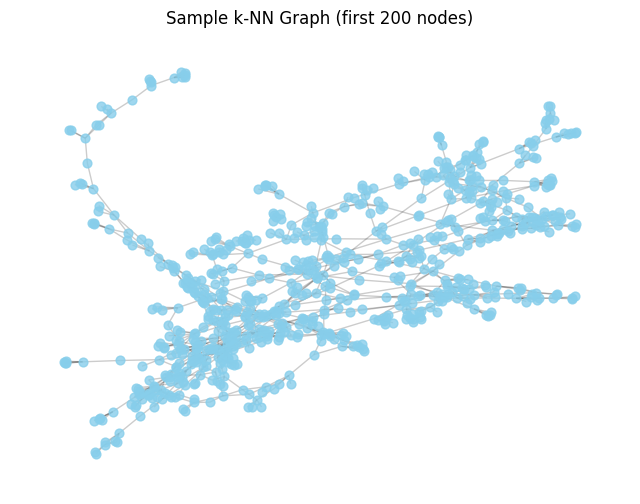

In [12]:

X = df_smote.drop(columns=['fraud_reported'])
X = X.select_dtypes(include=['float64', 'int64', 'bool'])
X = X.astype(float) # convert bool to float for PyTorch
y = df_smote['fraud_reported'].values


k = 5
A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
A.data = np.exp(-A.data**2 / X.shape[1])
A = A.tocoo()


# convert to pyTorch geometric data for gnn
edge_index = torch.from_numpy(
    np.vstack((A.row, A.col)).astype(np.int64)
)
edge_weight = torch.tensor(A.data, dtype=torch.float)
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

print(graph_data)
print(f"Nodes: {graph_data.num_nodes}, Edges: {graph_data.num_edges}")




num_sub_nodes = min(200, graph_data.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data.edge_index[:, :min(graph_data.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph (first 200 nodes)")
plt.axis("off")
plt.show()


# GCN (Smote)

In [13]:
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=graph_data.y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

# define model
class FraudGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



#training and eval
def train_and_evaluate(graph_data, hidden_channels, lr, dropout, epochs=100):
    model = FraudGCN(
        in_channels=graph_data.num_features,
        hidden_channels=hidden_channels,
        out_channels=2,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    out = model(graph_data)
    preds = out[graph_data.test_mask].argmax(dim=1).detach()
    y_true = graph_data.y[graph_data.test_mask].detach()

    recall = recall_score(y_true, preds, zero_division=0)
    precision = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    accuracy = accuracy_score(y_true, preds)

    # get pred distribution
    unique, counts = torch.unique(preds, return_counts=True)
    dist_dict = {int(u): int(c) for u, c in zip(unique, counts)}
    print(f"Prediction distribution (test set): {dist_dict}")

    return recall, precision, f1, accuracy, model


# hyperparam tuning
param_grid = {
    'hidden_channels': [32, 64, 128],
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [50, 100]
}

results = []
best_f1 = 0
best_params = None
best_model = None

print("\n Starting hyperparameter tuning using F1-score:\n")

for hidden in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                recall, precision, f1, accuracy, model = train_and_evaluate(graph_data, hidden, lr, dropout, epochs)

                preds = model(graph_data).argmax(dim=1)[graph_data.test_mask].detach().numpy()
                pred_dist = dict(pd.Series(preds).value_counts())
                print(f"Prediction distribution (test set): {pred_dist}")
                print(f"hidden={hidden}, lr={lr}, dropout={dropout}, epochs={epochs} "
                      f"--> Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Acc={accuracy:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (hidden, lr, dropout, epochs)
                    best_model = model


print("\n Best Hyperparameters by F1 score:")
print(f"Hidden Channels: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Epochs: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")




# model on test
best_model.eval()
with torch.no_grad():
    out_test = best_model(graph_data_test)
    preds_test = out_test.argmax(dim=1)

# eval


print("\n Test Set Evaluation:")
print(confusion_matrix(y_test, preds_test.numpy()))
print(classification_report(y_test, preds_test.numpy(), digits=4))



 Starting hyperparameter tuning using F1-score:

Prediction distribution (test set): {0: 119, 1: 123}
Prediction distribution (test set): {1: 123, 0: 119}
hidden=32, lr=0.1, dropout=0.2, epochs=50 --> Recall=0.8017, Precision=0.7886, F1=0.7951, Acc=0.7934
Prediction distribution (test set): {0: 127, 1: 115}
Prediction distribution (test set): {0: 127, 1: 115}
hidden=32, lr=0.1, dropout=0.2, epochs=100 --> Recall=0.9091, Precision=0.9565, F1=0.9322, Acc=0.9339
Prediction distribution (test set): {0: 242}
Prediction distribution (test set): {0: 242}
hidden=32, lr=0.1, dropout=0.3, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.5000
Prediction distribution (test set): {0: 120, 1: 122}
Prediction distribution (test set): {1: 122, 0: 120}
hidden=32, lr=0.1, dropout=0.3, epochs=100 --> Recall=0.9587, Precision=0.9508, F1=0.9547, Acc=0.9545
Prediction distribution (test set): {0: 65, 1: 177}
Prediction distribution (test set): {1: 177, 0: 65}
hidden=32, lr=0.1, dropout=0.5, 

# Creating graph (Oversampled)

Data(x=[1005, 126], edge_index=[2, 5025], y=[1005], edge_weight=[5025])
Nodes: 1005, Edges: 5025


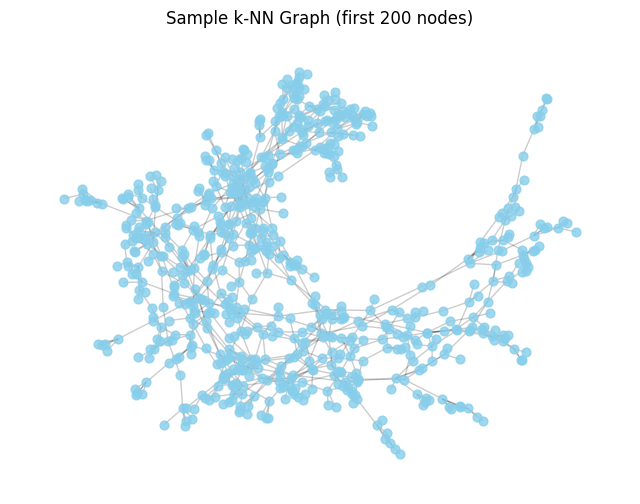

In [21]:

X = df_oversampled.drop(columns=['fraud_reported'])
X = X.select_dtypes(include=['float64', 'int64', 'bool'])
X = X.astype(float) # convert bool to float for PyTorch
y = df_oversampled['fraud_reported'].values

k = 5
A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
A.data = np.exp(-A.data**2 / X.shape[1])
A = A.tocoo()


# convert to pyTorch geometric data for gnn
edge_index = torch.from_numpy(
    np.vstack((A.row, A.col)).astype(np.int64)
)
edge_weight = torch.tensor(A.data, dtype=torch.float)
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

print(graph_data)
print(f"Nodes: {graph_data.num_nodes}, Edges: {graph_data.num_edges}")




num_sub_nodes = min(200, graph_data.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data.edge_index[:, :min(graph_data.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph (first 200 nodes)")
plt.axis("off")
plt.show()



# GCN (Oversampled)

In [25]:
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=graph_data.y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

# define model
class FraudGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



#training and eval
def train_and_evaluate(graph_data, hidden_channels, lr, dropout, epochs=100):
    model = FraudGCN(
        in_channels=graph_data.num_features,
        hidden_channels=hidden_channels,
        out_channels=2,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    out = model(graph_data)
    preds = out[graph_data.test_mask].argmax(dim=1).detach()
    y_true = graph_data.y[graph_data.test_mask].detach()

    recall = recall_score(y_true, preds, zero_division=0)
    precision = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    accuracy = accuracy_score(y_true, preds)

    # get pred distribution
    unique, counts = torch.unique(preds, return_counts=True)
    dist_dict = {int(u): int(c) for u, c in zip(unique, counts)}
    print(f"Prediction distribution (test set): {dist_dict}")

    return recall, precision, f1, accuracy, model


# hyperparam tuning
param_grid = {
    'hidden_channels': [32, 64, 128],
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [50, 100]
}

results = []
best_f1 = 0
best_params = None
best_model = None

print("\n Starting hyperparameter tuning using F1-score:\n")

for hidden in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                recall, precision, f1, accuracy, model = train_and_evaluate(graph_data, hidden, lr, dropout, epochs)

                preds = model(graph_data).argmax(dim=1)[graph_data.test_mask].detach().numpy()
                pred_dist = dict(pd.Series(preds).value_counts())
                print(f"Prediction distribution (test set): {pred_dist}")
                print(f"hidden={hidden}, lr={lr}, dropout={dropout}, epochs={epochs} "
                      f"--> Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Acc={accuracy:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (hidden, lr, dropout, epochs)
                    best_model = model


print("\n Best Hyperparameters by F1 score:")
print(f"Hidden Channels: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Epochs: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")




# model on test
best_model.eval()
with torch.no_grad():
    out_test = best_model(graph_data_test)
    preds_test = out_test.argmax(dim=1)

# eval


print("\n Test Set Evaluation:")
print(confusion_matrix(y_test, preds_test.numpy()))
print(classification_report(y_test, preds_test.numpy(), digits=4))



 Starting hyperparameter tuning using F1-score:

Prediction distribution (test set): {0: 201}
Prediction distribution (test set): {0: 201}
hidden=32, lr=0.1, dropout=0.2, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.6020
Prediction distribution (test set): {0: 201}
Prediction distribution (test set): {0: 201}
hidden=32, lr=0.1, dropout=0.2, epochs=100 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.6020
Prediction distribution (test set): {0: 126, 1: 75}
Prediction distribution (test set): {0: 126, 1: 75}
hidden=32, lr=0.1, dropout=0.3, epochs=50 --> Recall=0.5375, Precision=0.5733, F1=0.5548, Acc=0.6567
Prediction distribution (test set): {0: 132, 1: 69}
Prediction distribution (test set): {0: 132, 1: 69}
hidden=32, lr=0.1, dropout=0.3, epochs=100 --> Recall=0.6625, Precision=0.7681, F1=0.7114, Acc=0.7861
Prediction distribution (test set): {0: 201}
Prediction distribution (test set): {0: 201}
hidden=32, lr=0.1, dropout=0.5, epochs=50 --> Recall=0.0000, Preci

In [16]:
# Follow up on oversampled since it performed the best
print(f"Samples (nodes): {X.shape[0]}, Features: {X.shape[1]}")
print(f"Feature-to-sample ratio: {X.shape[1] / X.shape[0]:.3f}")
# curse of dim no issue

Samples (nodes): 1005, Features: 126
Feature-to-sample ratio: 0.125


# Creating graph (Oversampled, manhattan)

Data(x=[1005, 126], edge_index=[2, 5025], y=[1005], edge_weight=[5025])
Nodes: 1005, Edges: 5025


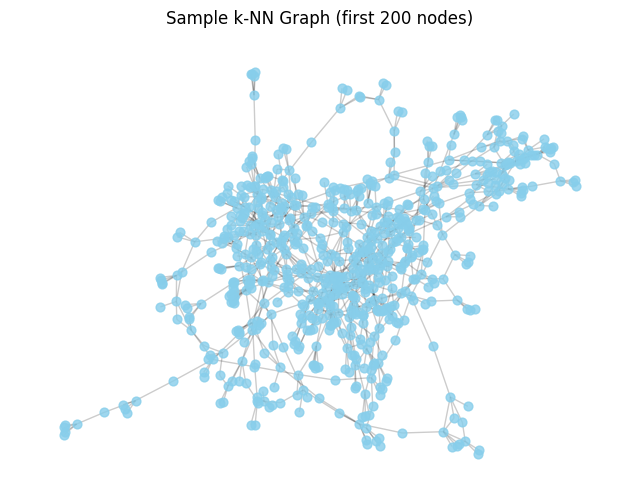

In [8]:

X = df_oversampled.drop(columns=['fraud_reported'])
X = X.select_dtypes(include=['float64', 'int64', 'bool'])
X = X.astype(float) # convert bool to float for PyTorch
y = df_oversampled['fraud_reported'].values

k = 5
A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False, metric='minkowski', p=1)
A.data = np.exp(-A.data**2 / X.shape[1])
A = A.tocoo()


# convert to pyTorch geometric data for gnn
edge_index = torch.from_numpy(
    np.vstack((A.row, A.col)).astype(np.int64)
)
edge_weight = torch.tensor(A.data, dtype=torch.float)
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

print(graph_data)
print(f"Nodes: {graph_data.num_nodes}, Edges: {graph_data.num_edges}")




num_sub_nodes = min(200, graph_data.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data.edge_index[:, :min(graph_data.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph (first 200 nodes)")
plt.axis("off")
plt.show()



# GCN (Oversampled, Manhattan)

In [10]:
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=graph_data.y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

# define model
class FraudGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



#training and eval
def train_and_evaluate(graph_data, hidden_channels, lr, dropout, epochs=100):
    model = FraudGCN(
        in_channels=graph_data.num_features,
        hidden_channels=hidden_channels,
        out_channels=2,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    out = model(graph_data)
    preds = out[graph_data.test_mask].argmax(dim=1).detach()
    y_true = graph_data.y[graph_data.test_mask].detach()

    recall = recall_score(y_true, preds, zero_division=0)
    precision = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    accuracy = accuracy_score(y_true, preds)

    # get pred distribution
    unique, counts = torch.unique(preds, return_counts=True)
    dist_dict = {int(u): int(c) for u, c in zip(unique, counts)}
    print(f"Prediction distribution (test set): {dist_dict}")

    return recall, precision, f1, accuracy, model


# hyperparam tuning
param_grid = {
    'hidden_channels': [32, 64, 128],
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [50, 100]
}

results = []
best_f1 = 0
best_params = None
best_model = None

print("\n Starting hyperparameter tuning using F1-score:\n")

for hidden in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                recall, precision, f1, accuracy, model = train_and_evaluate(graph_data, hidden, lr, dropout, epochs)

                preds = model(graph_data).argmax(dim=1)[graph_data.test_mask].detach().numpy()
                pred_dist = dict(pd.Series(preds).value_counts())
                print(f"Prediction distribution (test set): {pred_dist}")
                print(f"hidden={hidden}, lr={lr}, dropout={dropout}, epochs={epochs} "
                      f"--> Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Acc={accuracy:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (hidden, lr, dropout, epochs)
                    best_model = model


print("\n Best Hyperparameters by F1 score:")
print(f"Hidden Channels: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Epochs: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")




# model on test
best_model.eval()
with torch.no_grad():
    out_test = best_model(graph_data_test_man)
    preds_test = out_test.argmax(dim=1)

# eval


print("\n Test Set Evaluation:")
print(confusion_matrix(y_test, preds_test.numpy()))
print(classification_report(y_test, preds_test.numpy(), digits=4))



 Starting hyperparameter tuning using F1-score:

Prediction distribution (test set): {0: 201}
Prediction distribution (test set): {0: 201}
hidden=32, lr=0.1, dropout=0.2, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.6020
Prediction distribution (test set): {0: 134, 1: 67}
Prediction distribution (test set): {0: 134, 1: 67}
hidden=32, lr=0.1, dropout=0.2, epochs=100 --> Recall=0.6250, Precision=0.7463, F1=0.6803, Acc=0.7662
Prediction distribution (test set): {0: 201}
Prediction distribution (test set): {0: 201}
hidden=32, lr=0.1, dropout=0.3, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.6020
Prediction distribution (test set): {0: 131, 1: 70}
Prediction distribution (test set): {0: 131, 1: 70}
hidden=32, lr=0.1, dropout=0.3, epochs=100 --> Recall=0.7000, Precision=0.8000, F1=0.7467, Acc=0.8109
Prediction distribution (test set): {0: 126, 1: 75}
Prediction distribution (test set): {0: 126, 1: 75}
hidden=32, lr=0.1, dropout=0.5, epochs=50 --> Recall

# Creating graph (Adasyn)

Data(x=[1203, 126], edge_index=[2, 6015], y=[1203], edge_weight=[6015])
Nodes: 1203, Edges: 6015


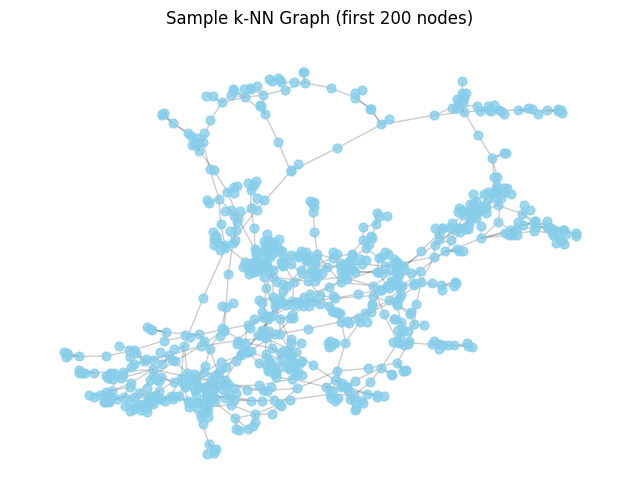

In [17]:


X = df_adasyn.drop(columns=['fraud_reported'])
X = X.select_dtypes(include=['float64', 'int64', 'bool'])
X = X.astype(float) # convert bool to float for PyTorch
y = df_adasyn['fraud_reported'].values

k = 5
A = kneighbors_graph(X, n_neighbors=k, mode='distance', include_self=False)
A.data = np.exp(-A.data**2 / X.shape[1])
A = A.tocoo()


# convert to pyTorch geometric data for gnn
edge_index = torch.from_numpy(
    np.vstack((A.row, A.col)).astype(np.int64)
)
edge_weight = torch.tensor(A.data, dtype=torch.float)
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

print(graph_data)
print(f"Nodes: {graph_data.num_nodes}, Edges: {graph_data.num_edges}")




num_sub_nodes = min(200, graph_data.num_nodes)
sub_nodes = np.arange(num_sub_nodes)


G = nx.Graph()
edges = graph_data.edge_index[:, :min(graph_data.edge_index.shape[1], num_sub_nodes*k)].t().tolist()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42, k=0.3)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Sample k-NN Graph (first 200 nodes)")
plt.axis("off")
plt.show()



# GCN (Adasyn)

In [18]:
num_nodes = graph_data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=graph_data.y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

# define model
class FraudGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



#training and eval
def train_and_evaluate(graph_data, hidden_channels, lr, dropout, epochs=100):
    model = FraudGCN(
        in_channels=graph_data.num_features,
        hidden_channels=hidden_channels,
        out_channels=2,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
        loss.backward()
        optimizer.step()

    # eval
    model.eval()
    out = model(graph_data)
    preds = out[graph_data.test_mask].argmax(dim=1).detach()
    y_true = graph_data.y[graph_data.test_mask].detach()

    recall = recall_score(y_true, preds, zero_division=0)
    precision = precision_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    accuracy = accuracy_score(y_true, preds)

    # get pred distribution
    unique, counts = torch.unique(preds, return_counts=True)
    dist_dict = {int(u): int(c) for u, c in zip(unique, counts)}
    print(f"Prediction distribution (test set): {dist_dict}")

    return recall, precision, f1, accuracy, model


# hyperparam tuning
param_grid = {
    'hidden_channels': [32, 64, 128],
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [50, 100]
}

results = []
best_f1 = 0
best_params = None
best_model = None

print("\n Starting hyperparameter tuning using F1-score:\n")

for hidden in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for dropout in param_grid['dropout']:
            for epochs in param_grid['epochs']:
                recall, precision, f1, accuracy, model = train_and_evaluate(graph_data, hidden, lr, dropout, epochs)

                preds = model(graph_data).argmax(dim=1)[graph_data.test_mask].detach().numpy()
                pred_dist = dict(pd.Series(preds).value_counts())
                print(f"Prediction distribution (test set): {pred_dist}")
                print(f"hidden={hidden}, lr={lr}, dropout={dropout}, epochs={epochs} "
                      f"--> Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Acc={accuracy:.4f}")

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (hidden, lr, dropout, epochs)
                    best_model = model


print("\n Best Hyperparameters by F1 score:")
print(f"Hidden Channels: {best_params[0]}")
print(f"Learning Rate: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Epochs: {best_params[3]}")
print(f"Best F1-Score: {best_f1:.4f}")




# model on test
best_model.eval()
with torch.no_grad():
    out_test = best_model(graph_data_test)
    preds_test = out_test.argmax(dim=1)

# eval


print("\n Test Set Evaluation:")
print(confusion_matrix(y_test, preds_test.numpy()))
print(classification_report(y_test, preds_test.numpy(), digits=4))



 Starting hyperparameter tuning using F1-score:

Prediction distribution (test set): {0: 112, 1: 129}
Prediction distribution (test set): {1: 129, 0: 112}
hidden=32, lr=0.1, dropout=0.2, epochs=50 --> Recall=0.8000, Precision=0.7442, F1=0.7711, Acc=0.7635
Prediction distribution (test set): {0: 36, 1: 205}
Prediction distribution (test set): {1: 205, 0: 36}
hidden=32, lr=0.1, dropout=0.2, epochs=100 --> Recall=0.8750, Precision=0.5122, F1=0.6462, Acc=0.5228
Prediction distribution (test set): {0: 241}
Prediction distribution (test set): {0: 241}
hidden=32, lr=0.1, dropout=0.3, epochs=50 --> Recall=0.0000, Precision=0.0000, F1=0.0000, Acc=0.5021
Prediction distribution (test set): {0: 127, 1: 114}
Prediction distribution (test set): {0: 127, 1: 114}
hidden=32, lr=0.1, dropout=0.3, epochs=100 --> Recall=0.9083, Precision=0.9561, F1=0.9316, Acc=0.9336
Prediction distribution (test set): {1: 241}
Prediction distribution (test set): {1: 241}
hidden=32, lr=0.1, dropout=0.5, epochs=50 --> Re

| Metric              | Original | SMOTE | Oversampled |ADASYN|
| ------------------- | -------- | ----- | ----------- | ---- |
| **Accuracy**        | 0.73     | 0.68  | 0.77        | 0.74 |
| **Fraud Precision** | 0.44     | 0.35  | 0.55        | 0.48 |
| **Fraud Recall**    | 0.28     | 0.32  | 0.48        | 0.46 |
| **Fraud F1**        | 0.34     | 0.33  | 0.51        | 0.47 |